In [75]:
# Build model
from keras.metrics import AUC
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

DATA = "HALData-master"
window_size = 20

def create_rolling_windows(data, win_size):
    """
    Converts dataframe into two windowed numpy arrays
    :param data: dataframe including the features and target as the last column
    :param win_size: the size of the window for the NN
    :return: Features as a numpy array and Target as numpy array
    """
    X, y = [], []
    for i in range(len(data) - win_size):
        ## adds features to rolling window

        X.append(data[i:i + win_size, :-1])
        ## adds target to rolling window
        y.append(data[i + win_size, -1])
    return X, y

def load_csv_data(data_dir, keyword, label):
    """
    Loads data from CSV
    :param data_dir:
    :param keyword: whether its vanilla or hacks
    :param label: the target label (0 or 1)
    :return: feature numpy array, target numpy array
    """
    features = ['ANGLE_DOT', 'DISTANCE']
    target = 'cheating'
    column_names = ['EVENT', 'XZ_DELTA', 'Y_DELTA', 'PITCH_DELTA', 'YAW_DELTA', 'SPEED_LEVEL', 'ON_GROUND', 'ANGLE_DOT', 'DISTANCE', 'PING', 'TPS', 'TIMESTAMP', 'offset']
    X = []
    y = []
    for f in os.listdir(data_dir):
        if keyword in f:
            file_path = os.path.join(data_dir, f)
            df = pd.read_csv(file_path, names=column_names, comment='#', header=None)
            attack_df = df.loc[df['EVENT'] == 'attackInfo']
            attack_df = attack_df[features]
            attack_df[target] = float(label)
            attack_df.reset_index(drop=True,inplace=True)
            attack_df.dropna(axis=0, inplace=True)
            windowed_features, windowed_targets = create_rolling_windows(attack_df.values,20)
            X.extend(windowed_targets)
            y.extend(windowed_features)
    return np.array(X), np.array(y)

def prepare_data(data_dir):
    """
    Prepares training and testing data ready to be used for the model
    :param data_dir:
    :return: training and testing numpy arrays
    """
    X_van, y_van = load_csv_data(os.path.join(data_dir, "Vanilla"), ".csv", 0)
    X_hac, y_hac = load_csv_data(os.path.join(data_dir, "Hacks"), ".csv", 1)
    X = np.concatenate((X_van, X_hac), axis=0)
    Y = np.concatenate((y_van, y_hac), axis=0)
    X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.40, shuffle=True)
    return y_train, y_test, X_train, X_test

def create_model():
    """
    Creates model containing an input layer, 2 hidden layers and an output layer.
    :return: the model
    """
    model = Sequential()
    model.add(Input((window_size, 2)))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', AUC(name='auc')])
    
    return model

In [76]:
# Get training and testing data
X_train, X_test, y_train, y_test = prepare_data(DATA)

In [77]:
# Create the model
model = create_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=35, batch_size=32)
score = model.evaluate(X_test, y_test, batch_size=32)
for i in range(len(score)):
    print(model.metrics_names[i], score[i])

Epoch 1/35
496/496 [==============================] - 6s 10ms/step - loss: 0.2990 - accuracy: 0.8527 - auc: 0.8683 - val_loss: 0.2736 - val_accuracy: 0.8666 - val_auc: 0.8981
Epoch 2/35
496/496 [==============================] - 4s 8ms/step - loss: 0.2452 - accuracy: 0.8906 - auc: 0.9194 - val_loss: 0.2005 - val_accuracy: 0.9146 - val_auc: 0.9484
Epoch 3/35
496/496 [==============================] - 4s 9ms/step - loss: 0.1843 - accuracy: 0.9239 - auc: 0.9556 - val_loss: 0.1541 - val_accuracy: 0.9396 - val_auc: 0.9693
Epoch 4/35
496/496 [==============================] - 5s 9ms/step - loss: 0.1523 - accuracy: 0.9420 - auc: 0.9687 - val_loss: 0.1414 - val_accuracy: 0.9451 - val_auc: 0.9746
Epoch 5/35
496/496 [==============================] - 4s 9ms/step - loss: 0.1350 - accuracy: 0.9493 - auc: 0.9749 - val_loss: 0.1170 - val_accuracy: 0.9553 - val_auc: 0.9816
Epoch 6/35
496/496 [==============================] - 5s 9ms/step - loss: 0.1277 - accuracy: 0.9498 - auc: 0.9788 - val_loss: 0.1

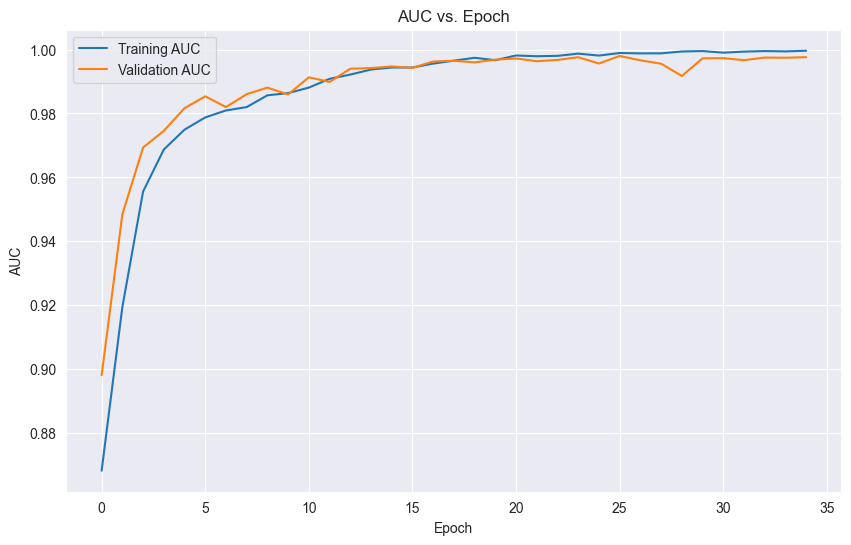

In [84]:
# AUC vs Epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

331/331 [==============================] - 1s 4ms/step


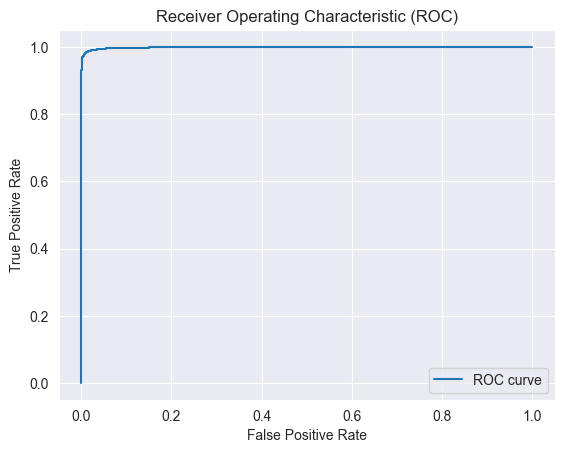

In [85]:
# Make predictions on test features
y_pred = model.predict(X_test).ravel()
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

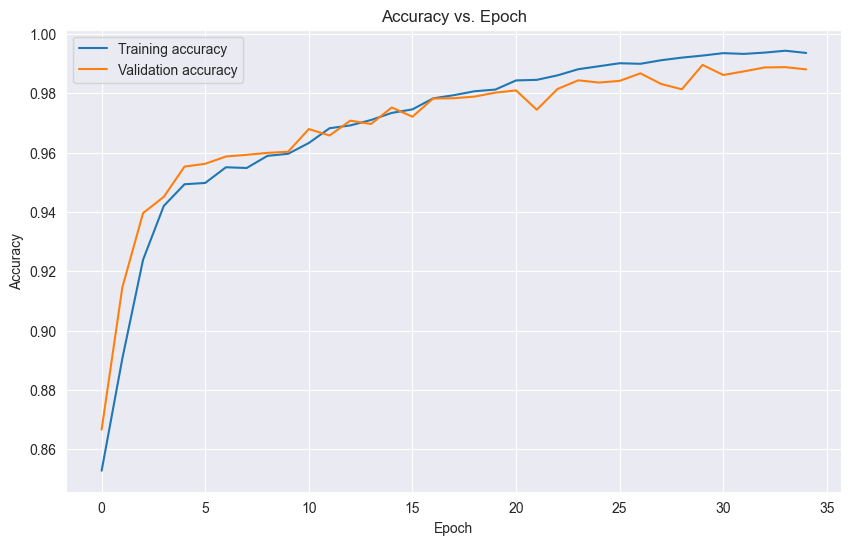

In [86]:
# Accuracy vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

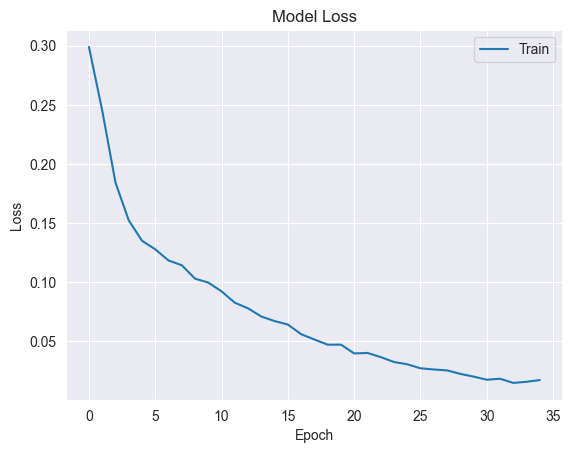

In [87]:
# Loss vs Epoch
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train'], loc='upper right')
    plt.show()
plot_loss(history)

In [88]:
# Saves the model
model.save('anticheat_model.h5')

In [89]:
# Reconstructing model
import keras
reconstructed_model = keras.models.load_model('anticheat_model.h5')